# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 2 x 1.5 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:

    -First experiment:
        - (0, 0, 0.01)
        - (10, 10, 0.01)
    -Second experiment:
    
        - (0, 0, 0.2)
        - (10, 10, 0.2)
- The simulator runs during 10 minutes in fast mode which is translated into 12 hours of collected data.

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
import matplotlib.pyplot as plt

Using TensorFlow backend.


# First Experiment

In [2]:
csv_file = 'robot_info_dataset-jumped.csv'
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
0,0,0.920614,0.761198,168.209483,-0.070670,0.011198,-11.790739,1.085179,0.790267,0.893342,...,1.139790,1.144901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.850135,0.775909,168.212418,-0.070479,0.014711,0.002935,0.571635,0.596799,0.883340,...,0.830057,1.028332,-0.513544,-0.193468,-0.010002,-0.430864,-0.070277,-0.387726,-0.309733,-0.116568
2,2,0.779657,0.790625,168.209551,-0.070478,0.014716,-0.002867,0.581452,0.904627,0.689004,...,0.491200,0.889130,0.009817,0.307828,-0.194336,0.239518,0.206480,0.293382,-0.338857,-0.139203
3,3,0.709174,0.805340,168.212871,-0.070483,0.014715,0.003319,0.956302,0.842911,0.796714,...,1.246415,0.712158,0.374849,-0.061716,0.107710,0.075412,-0.345782,-0.084918,0.755215,-0.176971
4,4,0.638698,0.820056,168.208857,-0.070477,0.014716,-0.004013,0.671731,0.779896,0.962191,...,0.567806,0.595164,-0.284570,-0.063014,0.165477,0.005216,0.128150,-0.054777,-0.678608,-0.116994


## Data pre-processing

The data collected 1384848 samples.

In [3]:
df.shape

(65342, 23)

The data set contains some null values so they should be deleted from the samples.

In [4]:
df = df.dropna()

Now the data will be normalized.

In [5]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df.describe()

,Unnamed: 0,x,y,theta,dx,dy,dtheta,sensor_1,sensor_2,sensor_3,...,sensor_7,sensor_8,dsensor_1,dsensor_2,dsensor_3,dsensor_4,dsensor_5,dsensor_6,dsensor_7,dsensor_8
count,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,...,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000,65341.000000
mean,0.500000,0.498321,0.504753,0.502063,0.499785,0.500412,0.501624,0.239976,0.236145,0.261438,...,0.251293,0.242889,0.449485,0.468761,0.513828,0.507022,0.519272,0.531825,0.446832,0.426383
std,0.288682,0.272549,0.264025,0.290735,0.353425,0.335002,0.114192,0.140647,0.149030,0.169722,...,0.160999,0.143636,0.078247,0.073403,0.077416,0.078125,0.081846,0.080184,0.072415,0.077850
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.255777,0.269104,0.251332,0.139102,0.181098,0.496242,0.127116,0.108774,0.119219,...,0.112714,0.127502,0.412053,0.436092,0.483323,0.477268,0.488782,0.501383,0.415117,0.388997
50%,0.500000,0.498537,0.503544,0.498631,0.500020,0.500797,0.501627,0.216759,0.215659,0.237666,...,0.224880,0.220298,0.442927,0.467409,0.516314,0.512401,0.524693,0.534465,0.445713,0.419784
75%,0.750000,0.735371,0.740156,0.752400,0.860369,0.821281,0.506991,0.328127,0.337889,0.375692,...,0.360337,0.333973,0.479438,0.498031,0.547039,0.544322,0.557577,0.565527,0.475271,0.456114
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [6]:

# train size
test_size_percentage = .2
train_size_percentage = .6
ds_size = normalized_df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
normalized_df = normalized_df.sample(frac=1)

# separate inputs from outputs
inputs = normalized_df[['x', 'y', 'theta']]
targets = normalized_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:(train_size + test_size)]
test_targets = targets[train_size:(train_size + test_size)]

# validation
validation_inputs = inputs[(train_size + test_size):]
validation_targets = targets[(train_size + test_size):]

## Random Forsest

We are going to fit a random forest tree with 5 trees and each tree will handle $\sqrt n$ number of variables available for splitting at each tree node.

In [7]:
n_features = 8;
max_features = round(math.sqrt(n_features))

reg = RandomForestRegressor(n_estimators=5, max_features=max_features, criterion='mse', verbose=False, n_jobs=1)
reg.fit(train_inputs, train_targets)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=1, oob_score=False,
                      random_state=None, verbose=False, warm_start=False)

In [8]:
print("Features importances x: %f, y: %f, theta: %f" %(reg.feature_importances_[0], reg.feature_importances_[1], reg.feature_importances_[2]))
print()
predictions_targets = reg.predict(test_inputs)

print("R^2 score: %f \n" % reg.score(test_inputs, test_targets))

# Calculate the absolute errors
errors = abs(predictions_targets - test_targets)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:')
print(round(np.mean(np.mean(errors)), 8))
print()

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_targets)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print()
print('Accuracy:')
print(round(np.mean(accuracy), 2), '%.')
print()

nmse = np.mean((predictions_targets - test_targets)**2/np.var(test_targets))
print("NMSE")
print(np.mean(nmse))

Features importances x: 0.314563, y: 0.249262, theta: 0.436175

R^2 score: 0.801145 

Mean Absolute Error:
0.04795014


Accuracy:
76.94 %.

NMSE
0.20109603291958672


/usr/local/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


## Neural Network


As input the neural network receives the x, y coordinates and rotation angle $\theta$. The output are the sensor measurements. The hidden layer uses relu as activation function. The loss function is MSE and it serves as a metric
to minimize the function.

![NN Architecture](nn_architecture.png)

In [9]:
def get_model(train_data):
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(8))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

In [16]:
k = 5
num_val_samples = len(train_inputs) // k
validation_scores = []
num_epochs = 150
histories = []
nmse = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_inputs[:i * num_val_samples],
         train_inputs[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], axis=0)
    
 
    model = get_model(train_inputs)
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    histories.append(history.history)
    
    predictions_targets = model.predict(val_data)
    nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
    

processing fold # 0
Train on 31364 samples, validate on 7840 samples
Epoch 1/150
31364/31364 [==============================] - 27s 868us/step - loss: 0.0191 - mae: 0.1093 - val_loss: 0.0170 - val_mae: 0.1035
Epoch 2/150
31364/31364 [==============================] - 27s 852us/step - loss: 0.0161 - mae: 0.0995 - val_loss: 0.0153 - val_mae: 0.0958
Epoch 3/150
31364/31364 [==============================] - 27s 866us/step - loss: 0.0145 - mae: 0.0937 - val_loss: 0.0140 - val_mae: 0.0919
Epoch 4/150
31364/31364 [==============================] - 27s 849us/step - loss: 0.0129 - mae: 0.0877 - val_loss: 0.0118 - val_mae: 0.0837
Epoch 5/150
31364/31364 [==============================] - 27s 850us/step - loss: 0.0122 - mae: 0.0849 - val_loss: 0.0125 - val_mae: 0.0859
Epoch 6/150
31364/31364 [==============================] - 27s 853us/step - loss: 0.0118 - mae: 0.0835 - val_loss: 0.0111 - val_mae: 0.0798
Epoch 7/150
31364/31364 [==============================] - 27s 858us/step - loss: 0.0116 - 

31364/31364 [==============================] - 26s 827us/step - loss: 0.0128 - mae: 0.0873 - val_loss: 0.0136 - val_mae: 0.0893
Epoch 59/150
31364/31364 [==============================] - 28s 887us/step - loss: 0.0128 - mae: 0.0873 - val_loss: 0.0121 - val_mae: 0.0857
Epoch 60/150
31364/31364 [==============================] - 29s 919us/step - loss: 0.0128 - mae: 0.0872 - val_loss: 0.0120 - val_mae: 0.0841
Epoch 61/150
31364/31364 [==============================] - 30s 943us/step - loss: 0.0128 - mae: 0.0871 - val_loss: 0.0126 - val_mae: 0.0876
Epoch 62/150
31364/31364 [==============================] - 28s 898us/step - loss: 0.0128 - mae: 0.0871 - val_loss: 0.0122 - val_mae: 0.0843
Epoch 63/150
31364/31364 [==============================] - 28s 901us/step - loss: 0.0129 - mae: 0.0871 - val_loss: 0.0123 - val_mae: 0.0843
Epoch 64/150
31364/31364 [==============================] - 33s 1ms/step - loss: 0.0129 - mae: 0.0872 - val_loss: 0.0171 - val_mae: 0.1016
Epoch 65/150
31364/31364 [==

31364/31364 [==============================] - 27s 851us/step - loss: 0.0137 - mae: 0.0910 - val_loss: 0.0137 - val_mae: 0.0913
Epoch 117/150
31364/31364 [==============================] - 27s 846us/step - loss: 0.0139 - mae: 0.0915 - val_loss: 0.0143 - val_mae: 0.0929
Epoch 118/150
31364/31364 [==============================] - 26s 845us/step - loss: 0.0139 - mae: 0.0916 - val_loss: 0.0158 - val_mae: 0.0983
Epoch 119/150
31364/31364 [==============================] - 27s 848us/step - loss: 0.0139 - mae: 0.0916 - val_loss: 0.0138 - val_mae: 0.0910
Epoch 120/150
31364/31364 [==============================] - 26s 842us/step - loss: 0.0140 - mae: 0.0917 - val_loss: 0.0136 - val_mae: 0.0905
Epoch 121/150
31364/31364 [==============================] - 26s 844us/step - loss: 0.0140 - mae: 0.0917 - val_loss: 0.0137 - val_mae: 0.0903
Epoch 122/150
31364/31364 [==============================] - 26s 839us/step - loss: 0.0140 - mae: 0.0917 - val_loss: 0.0143 - val_mae: 0.0930
Epoch 123/150
31364/

31364/31364 [==============================] - 26s 836us/step - loss: 0.0126 - mae: 0.0862 - val_loss: 0.0120 - val_mae: 0.0844
Epoch 24/150
31364/31364 [==============================] - 26s 833us/step - loss: 0.0128 - mae: 0.0870 - val_loss: 0.0126 - val_mae: 0.0865
Epoch 25/150
31364/31364 [==============================] - 26s 834us/step - loss: 0.0131 - mae: 0.0880 - val_loss: 0.0132 - val_mae: 0.0890
Epoch 26/150
31364/31364 [==============================] - 27s 846us/step - loss: 0.0133 - mae: 0.0890 - val_loss: 0.0127 - val_mae: 0.0867
Epoch 27/150
31364/31364 [==============================] - 26s 836us/step - loss: 0.0134 - mae: 0.0897 - val_loss: 0.0132 - val_mae: 0.0887
Epoch 28/150
31364/31364 [==============================] - 28s 895us/step - loss: 0.0134 - mae: 0.0895 - val_loss: 0.0129 - val_mae: 0.0886
Epoch 29/150
31364/31364 [==============================] - 30s 956us/step - loss: 0.0134 - mae: 0.0894 - val_loss: 0.0128 - val_mae: 0.0871
Epoch 30/150
31364/31364 [

31364/31364 [==============================] - 27s 870us/step - loss: 0.0127 - mae: 0.0870 - val_loss: 0.0122 - val_mae: 0.0853
Epoch 82/150
31364/31364 [==============================] - 29s 912us/step - loss: 0.0128 - mae: 0.0874 - val_loss: 0.0135 - val_mae: 0.0900
Epoch 83/150
31364/31364 [==============================] - 31s 988us/step - loss: 0.0129 - mae: 0.0879 - val_loss: 0.0144 - val_mae: 0.0925
Epoch 84/150
31364/31364 [==============================] - 28s 879us/step - loss: 0.0130 - mae: 0.0884 - val_loss: 0.0133 - val_mae: 0.0894
Epoch 85/150
31364/31364 [==============================] - 27s 874us/step - loss: 0.0132 - mae: 0.0889 - val_loss: 0.0141 - val_mae: 0.0922
Epoch 86/150
31364/31364 [==============================] - 27s 863us/step - loss: 0.0133 - mae: 0.0892 - val_loss: 0.0125 - val_mae: 0.0863
Epoch 87/150
31364/31364 [==============================] - 28s 880us/step - loss: 0.0134 - mae: 0.0898 - val_loss: 0.0126 - val_mae: 0.0866
Epoch 88/150
31364/31364 [

Epoch 139/150
31364/31364 [==============================] - 26s 835us/step - loss: 0.0119 - mae: 0.0843 - val_loss: 0.0124 - val_mae: 0.0877
Epoch 140/150
31364/31364 [==============================] - 26s 836us/step - loss: 0.0119 - mae: 0.0843 - val_loss: 0.0110 - val_mae: 0.0803
Epoch 141/150
31364/31364 [==============================] - 26s 838us/step - loss: 0.0119 - mae: 0.0842 - val_loss: 0.0110 - val_mae: 0.0806
Epoch 142/150
31364/31364 [==============================] - 28s 898us/step - loss: 0.0119 - mae: 0.0843 - val_loss: 0.0112 - val_mae: 0.0813
Epoch 143/150
31364/31364 [==============================] - 27s 846us/step - loss: 0.0119 - mae: 0.0843 - val_loss: 0.0112 - val_mae: 0.0814
Epoch 144/150
31364/31364 [==============================] - 27s 849us/step - loss: 0.0119 - mae: 0.0842 - val_loss: 0.0129 - val_mae: 0.0892
Epoch 145/150
31364/31364 [==============================] - 27s 871us/step - loss: 0.0119 - mae: 0.0843 - val_loss: 0.0115 - val_mae: 0.0830
Epoch 

Epoch 47/150
31364/31364 [==============================] - 28s 883us/step - loss: 0.0118 - mae: 0.0837 - val_loss: 0.0121 - val_mae: 0.0857
Epoch 48/150
31364/31364 [==============================] - 27s 873us/step - loss: 0.0118 - mae: 0.0838 - val_loss: 0.0118 - val_mae: 0.0848
Epoch 49/150
31364/31364 [==============================] - 31s 999us/step - loss: 0.0118 - mae: 0.0838 - val_loss: 0.0151 - val_mae: 0.0961
Epoch 50/150
31364/31364 [==============================] - 26s 845us/step - loss: 0.0118 - mae: 0.0839 - val_loss: 0.0123 - val_mae: 0.0857
Epoch 51/150
31364/31364 [==============================] - 27s 845us/step - loss: 0.0118 - mae: 0.0839 - val_loss: 0.0114 - val_mae: 0.0826
Epoch 52/150
31364/31364 [==============================] - 26s 842us/step - loss: 0.0118 - mae: 0.0838 - val_loss: 0.0111 - val_mae: 0.0819
Epoch 53/150
31364/31364 [==============================] - 33s 1ms/step - loss: 0.0118 - mae: 0.0838 - val_loss: 0.0122 - val_mae: 0.0856
Epoch 54/150
31

31364/31364 [==============================] - 30s 951us/step - loss: 0.0116 - mae: 0.0831 - val_loss: 0.0121 - val_mae: 0.0867
Epoch 106/150
31364/31364 [==============================] - 33s 1ms/step - loss: 0.0116 - mae: 0.0831 - val_loss: 0.0103 - val_mae: 0.0783
Epoch 107/150
31364/31364 [==============================] - 31s 996us/step - loss: 0.0116 - mae: 0.0831 - val_loss: 0.0104 - val_mae: 0.0784
Epoch 108/150
31364/31364 [==============================] - 29s 934us/step - loss: 0.0116 - mae: 0.0830 - val_loss: 0.0111 - val_mae: 0.0812
Epoch 109/150
31364/31364 [==============================] - 29s 939us/step - loss: 0.0116 - mae: 0.0830 - val_loss: 0.0119 - val_mae: 0.0838
Epoch 110/150
31364/31364 [==============================] - 29s 928us/step - loss: 0.0116 - mae: 0.0830 - val_loss: 0.0110 - val_mae: 0.0811
Epoch 111/150
31364/31364 [==============================] - 31s 987us/step - loss: 0.0116 - mae: 0.0832 - val_loss: 0.0104 - val_mae: 0.0782
Epoch 112/150
31364/31

31364/31364 [==============================] - 27s 871us/step - loss: 0.0125 - mae: 0.0861 - val_loss: 0.0126 - val_mae: 0.0864
Epoch 13/150
31364/31364 [==============================] - 27s 860us/step - loss: 0.0124 - mae: 0.0860 - val_loss: 0.0121 - val_mae: 0.0848
Epoch 14/150
31364/31364 [==============================] - 27s 864us/step - loss: 0.0123 - mae: 0.0857 - val_loss: 0.0121 - val_mae: 0.0849
Epoch 15/150
31364/31364 [==============================] - 27s 863us/step - loss: 0.0122 - mae: 0.0852 - val_loss: 0.0117 - val_mae: 0.0834
Epoch 16/150
31364/31364 [==============================] - 27s 868us/step - loss: 0.0121 - mae: 0.0848 - val_loss: 0.0122 - val_mae: 0.0852
Epoch 17/150
31364/31364 [==============================] - 27s 862us/step - loss: 0.0121 - mae: 0.0846 - val_loss: 0.0120 - val_mae: 0.0844
Epoch 18/150
31364/31364 [==============================] - 27s 869us/step - loss: 0.0120 - mae: 0.0845 - val_loss: 0.0118 - val_mae: 0.0835
Epoch 19/150
31364/31364 [

31364/31364 [==============================] - 85s 3ms/step - loss: 0.0128 - mae: 0.0875 - val_loss: 0.0130 - val_mae: 0.0873
Epoch 71/150
31364/31364 [==============================] - 81s 3ms/step - loss: 0.0129 - mae: 0.0875 - val_loss: 0.0142 - val_mae: 0.0939
Epoch 72/150
31364/31364 [==============================] - 82s 3ms/step - loss: 0.0128 - mae: 0.0874 - val_loss: 0.0120 - val_mae: 0.0841
Epoch 73/150
31364/31364 [==============================] - 83s 3ms/step - loss: 0.0129 - mae: 0.0875 - val_loss: 0.0127 - val_mae: 0.0868
Epoch 74/150
31364/31364 [==============================] - 84s 3ms/step - loss: 0.0129 - mae: 0.0875 - val_loss: 0.0119 - val_mae: 0.0839
Epoch 75/150
31364/31364 [==============================] - 85s 3ms/step - loss: 0.0129 - mae: 0.0876 - val_loss: 0.0130 - val_mae: 0.0879
Epoch 76/150
31364/31364 [==============================] - 87s 3ms/step - loss: 0.0129 - mae: 0.0875 - val_loss: 0.0126 - val_mae: 0.0858
Epoch 77/150
31364/31364 [==============

31364/31364 [==============================] - 27s 870us/step - loss: 0.0128 - mae: 0.0872 - val_loss: 0.0134 - val_mae: 0.0894
Epoch 129/150
31364/31364 [==============================] - 28s 881us/step - loss: 0.0128 - mae: 0.0871 - val_loss: 0.0146 - val_mae: 0.0939
Epoch 130/150
31364/31364 [==============================] - 28s 894us/step - loss: 0.0128 - mae: 0.0870 - val_loss: 0.0132 - val_mae: 0.0895
Epoch 131/150
31364/31364 [==============================] - 27s 877us/step - loss: 0.0128 - mae: 0.0871 - val_loss: 0.0124 - val_mae: 0.0850
Epoch 132/150
31364/31364 [==============================] - 27s 875us/step - loss: 0.0128 - mae: 0.0872 - val_loss: 0.0124 - val_mae: 0.0855
Epoch 133/150
31364/31364 [==============================] - 27s 866us/step - loss: 0.0128 - mae: 0.0872 - val_loss: 0.0123 - val_mae: 0.0856
Epoch 134/150
31364/31364 [==============================] - 27s 870us/step - loss: 0.0128 - mae: 0.0871 - val_loss: 0.0135 - val_mae: 0.0900
Epoch 135/150
31364/

31364/31364 [==============================] - 27s 868us/step - loss: 0.0141 - mae: 0.0920 - val_loss: 0.0140 - val_mae: 0.0923
Epoch 36/150
31364/31364 [==============================] - 28s 881us/step - loss: 0.0142 - mae: 0.0922 - val_loss: 0.0137 - val_mae: 0.0900
Epoch 37/150
31364/31364 [==============================] - 27s 868us/step - loss: 0.0144 - mae: 0.0926 - val_loss: 0.0139 - val_mae: 0.0912
Epoch 38/150
31364/31364 [==============================] - 27s 876us/step - loss: 0.0145 - mae: 0.0930 - val_loss: 0.0142 - val_mae: 0.0918
Epoch 39/150
31364/31364 [==============================] - 27s 875us/step - loss: 0.0146 - mae: 0.0934 - val_loss: 0.0145 - val_mae: 0.0933
Epoch 40/150
31364/31364 [==============================] - 27s 871us/step - loss: 0.0148 - mae: 0.0942 - val_loss: 0.0154 - val_mae: 0.0954
Epoch 41/150
31364/31364 [==============================] - 27s 874us/step - loss: 0.0148 - mae: 0.0946 - val_loss: 0.0170 - val_mae: 0.1010
Epoch 42/150
31364/31364 [

31364/31364 [==============================] - 27s 868us/step - loss: 0.0131 - mae: 0.0887 - val_loss: 0.0114 - val_mae: 0.0821
Epoch 94/150
31364/31364 [==============================] - 28s 883us/step - loss: 0.0131 - mae: 0.0888 - val_loss: 0.0162 - val_mae: 0.1004
Epoch 95/150
31364/31364 [==============================] - 27s 873us/step - loss: 0.0131 - mae: 0.0887 - val_loss: 0.0122 - val_mae: 0.0861
Epoch 96/150
31364/31364 [==============================] - 27s 871us/step - loss: 0.0131 - mae: 0.0888 - val_loss: 0.0122 - val_mae: 0.0851
Epoch 97/150
31364/31364 [==============================] - 28s 884us/step - loss: 0.0131 - mae: 0.0887 - val_loss: 0.0133 - val_mae: 0.0899
Epoch 98/150
31364/31364 [==============================] - 27s 868us/step - loss: 0.0131 - mae: 0.0888 - val_loss: 0.0140 - val_mae: 0.0926
Epoch 99/150
31364/31364 [==============================] - 27s 865us/step - loss: 0.0131 - mae: 0.0888 - val_loss: 0.0157 - val_mae: 0.0988
Epoch 100/150
31364/31364 

NMSE: 
0.5656547113984921


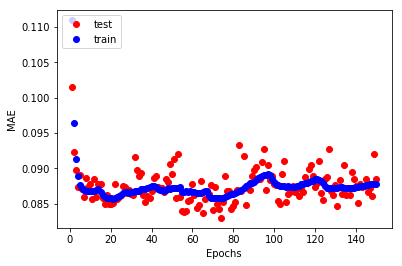

In [17]:
print("NMSE: ")
print(np.mean(nmse))

val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_mae_history) + 1), val_mae_history, 'ro')
plt.plot(range(1, len(mae_history) + 1), mae_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()


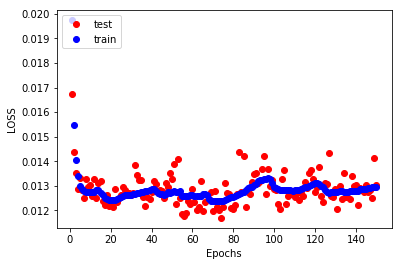

In [18]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

# Optimizing number of neurons

In [20]:

def get_model_with(train_data, number_neurons):
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(number_neurons, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(8))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

In [29]:
k = 3
num_val_samples = len(train_inputs) // k
num_epochs = 75
maes = []
val_maes = []
nmses = []
number_neurons = [2, 5, 8, 12, 16];

for nn in number_neurons:
    mae = []
    val_mae = []
    nmse = []
    print('PROCESSING NUMBER OF NEURONS ', nn);
    for i in range(k):
        print('PROCESSING FOLD #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples] 
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]], axis=0)


        model = get_model_with(train_inputs, nn)

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=1, verbose=1)
        mae.append(history.history['mae'])
        val_mae.append(history.history['val_mae'])
        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    maes.append(np.mean([x[num_epochs-1] for x in mae]))
    val_maes.append(np.mean([x[num_epochs-1] for x in val_mae]))
    nmses.append(np.mean(nmse))


PROCESSING NUMBER OF NEURONS  2
PROCESSING FOLD # 0
Train on 26136 samples, validate on 13068 samples
Epoch 1/75
26136/26136 [==============================] - 40s 2ms/step - loss: 0.0236 - mae: 0.1224 - val_loss: 0.0211 - val_mae: 0.1166
Epoch 2/75
26136/26136 [==============================] - 36s 1ms/step - loss: 0.0210 - mae: 0.1158 - val_loss: 0.0212 - val_mae: 0.1167
Epoch 3/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0210 - mae: 0.1158 - val_loss: 0.0213 - val_mae: 0.1169
Epoch 4/75
26136/26136 [==============================] - 36s 1ms/step - loss: 0.0210 - mae: 0.1161 - val_loss: 0.0211 - val_mae: 0.1168
Epoch 5/75
26136/26136 [==============================] - 39s 1ms/step - loss: 0.0211 - mae: 0.1165 - val_loss: 0.0212 - val_mae: 0.1170
Epoch 6/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0212 - mae: 0.1169 - val_loss: 0.0215 - val_mae: 0.1179
Epoch 7/75
26136/26136 [==============================] - 36s 1ms/step - los

26136/26136 [==============================] - 34s 1ms/step - loss: 0.0210 - mae: 0.1163 - val_loss: 0.0216 - val_mae: 0.1176
Epoch 60/75
26136/26136 [==============================] - 31s 1ms/step - loss: 0.0210 - mae: 0.1164 - val_loss: 0.0211 - val_mae: 0.1166
Epoch 61/75
26136/26136 [==============================] - 31s 1ms/step - loss: 0.0210 - mae: 0.1164 - val_loss: 0.0209 - val_mae: 0.1163
Epoch 62/75
26136/26136 [==============================] - 31s 1ms/step - loss: 0.0210 - mae: 0.1163 - val_loss: 0.0210 - val_mae: 0.1161
Epoch 63/75
26136/26136 [==============================] - 31s 1ms/step - loss: 0.0210 - mae: 0.1163 - val_loss: 0.0210 - val_mae: 0.1162
Epoch 64/75
26136/26136 [==============================] - 31s 1ms/step - loss: 0.0210 - mae: 0.1164 - val_loss: 0.0213 - val_mae: 0.1174
Epoch 65/75
26136/26136 [==============================] - 31s 1ms/step - loss: 0.0210 - mae: 0.1163 - val_loss: 0.0210 - val_mae: 0.1162
Epoch 66/75
26136/26136 [=====================

26136/26136 [==============================] - 35s 1ms/step - loss: 0.0214 - mae: 0.1178 - val_loss: 0.0210 - val_mae: 0.1168
Epoch 44/75
26136/26136 [==============================] - 37s 1ms/step - loss: 0.0214 - mae: 0.1178 - val_loss: 0.0209 - val_mae: 0.1156
Epoch 45/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0212 - mae: 0.1173 - val_loss: 0.0205 - val_mae: 0.1151
Epoch 46/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0207 - mae: 0.1156 - val_loss: 0.0201 - val_mae: 0.1136
Epoch 47/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0205 - mae: 0.1145 - val_loss: 0.0216 - val_mae: 0.1171
Epoch 48/75
26136/26136 [==============================] - 36s 1ms/step - loss: 0.0205 - mae: 0.1145 - val_loss: 0.0199 - val_mae: 0.1127
Epoch 49/75
26136/26136 [==============================] - 31s 1ms/step - loss: 0.0204 - mae: 0.1145 - val_loss: 0.0200 - val_mae: 0.1133
Epoch 50/75
26136/26136 [=====================

26136/26136 [==============================] - 34s 1ms/step - loss: 0.0224 - mae: 0.1212 - val_loss: 0.0226 - val_mae: 0.1212
Epoch 28/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0225 - mae: 0.1212 - val_loss: 0.0226 - val_mae: 0.1214
Epoch 29/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0225 - mae: 0.1211 - val_loss: 0.0227 - val_mae: 0.1217
Epoch 30/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0224 - mae: 0.1212 - val_loss: 0.0226 - val_mae: 0.1214
Epoch 31/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0225 - mae: 0.1212 - val_loss: 0.0226 - val_mae: 0.1211
Epoch 32/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0224 - mae: 0.1212 - val_loss: 0.0226 - val_mae: 0.1213
Epoch 33/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0224 - mae: 0.1211 - val_loss: 0.0226 - val_mae: 0.1217
Epoch 34/75
26136/26136 [=====================

26136/26136 [==============================] - 33s 1ms/step - loss: 0.0180 - mae: 0.1057 - val_loss: 0.0177 - val_mae: 0.1047
Epoch 11/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0177 - mae: 0.1046 - val_loss: 0.0177 - val_mae: 0.1052
Epoch 12/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0174 - mae: 0.1039 - val_loss: 0.0175 - val_mae: 0.1037
Epoch 13/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0173 - mae: 0.1037 - val_loss: 0.0174 - val_mae: 0.1034
Epoch 14/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0173 - mae: 0.1037 - val_loss: 0.0176 - val_mae: 0.1050
Epoch 15/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0173 - mae: 0.1038 - val_loss: 0.0173 - val_mae: 0.1036
Epoch 16/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0174 - mae: 0.1040 - val_loss: 0.0176 - val_mae: 0.1046
Epoch 17/75
26136/26136 [=====================

26136/26136 [==============================] - 32s 1ms/step - loss: 0.0176 - mae: 0.1040 - val_loss: 0.0184 - val_mae: 0.1060
Epoch 70/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0176 - mae: 0.1042 - val_loss: 0.0196 - val_mae: 0.1104
Epoch 71/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0176 - mae: 0.1042 - val_loss: 0.0189 - val_mae: 0.1073
Epoch 72/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0176 - mae: 0.1043 - val_loss: 0.0174 - val_mae: 0.1038
Epoch 73/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0177 - mae: 0.1045 - val_loss: 0.0174 - val_mae: 0.1039
Epoch 74/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0176 - mae: 0.1044 - val_loss: 0.0169 - val_mae: 0.1016
Epoch 75/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0176 - mae: 0.1044 - val_loss: 0.0170 - val_mae: 0.1022
PROCESSING FOLD # 1
Train on 26136 samples, va

26136/26136 [==============================] - 33s 1ms/step - loss: 0.0138 - mae: 0.0911 - val_loss: 0.0141 - val_mae: 0.0922
Epoch 54/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0138 - mae: 0.0911 - val_loss: 0.0135 - val_mae: 0.0912
Epoch 55/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0138 - mae: 0.0912 - val_loss: 0.0137 - val_mae: 0.0908
Epoch 56/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0138 - mae: 0.0910 - val_loss: 0.0135 - val_mae: 0.0895
Epoch 57/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0138 - mae: 0.0910 - val_loss: 0.0128 - val_mae: 0.0873
Epoch 58/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0138 - mae: 0.0908 - val_loss: 0.0134 - val_mae: 0.0896
Epoch 59/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0138 - mae: 0.0908 - val_loss: 0.0134 - val_mae: 0.0890
Epoch 60/75
26136/26136 [=====================

26136/26136 [==============================] - 32s 1ms/step - loss: 0.0142 - mae: 0.0923 - val_loss: 0.0140 - val_mae: 0.0917
Epoch 38/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0142 - mae: 0.0924 - val_loss: 0.0182 - val_mae: 0.1060
Epoch 39/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0142 - mae: 0.0922 - val_loss: 0.0143 - val_mae: 0.0934
Epoch 40/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0141 - mae: 0.0920 - val_loss: 0.0137 - val_mae: 0.0897
Epoch 41/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0140 - mae: 0.0918 - val_loss: 0.0140 - val_mae: 0.0917
Epoch 42/75
26136/26136 [==============================] - 32s 1ms/step - loss: 0.0140 - mae: 0.0917 - val_loss: 0.0139 - val_mae: 0.0920
Epoch 43/75
26136/26136 [==============================] - 33s 1ms/step - loss: 0.0140 - mae: 0.0916 - val_loss: 0.0153 - val_mae: 0.0950
Epoch 44/75
26136/26136 [=====================

26136/26136 [==============================] - 47s 2ms/step - loss: 0.0147 - mae: 0.0935 - val_loss: 0.0144 - val_mae: 0.0921
Epoch 21/75
26136/26136 [==============================] - 45s 2ms/step - loss: 0.0148 - mae: 0.0939 - val_loss: 0.0147 - val_mae: 0.0944
Epoch 22/75
26136/26136 [==============================] - 45s 2ms/step - loss: 0.0149 - mae: 0.0943 - val_loss: 0.0151 - val_mae: 0.0951
Epoch 23/75
26136/26136 [==============================] - 47s 2ms/step - loss: 0.0150 - mae: 0.0948 - val_loss: 0.0155 - val_mae: 0.0973
Epoch 24/75
26136/26136 [==============================] - 47s 2ms/step - loss: 0.0150 - mae: 0.0950 - val_loss: 0.0147 - val_mae: 0.0944
Epoch 25/75
26136/26136 [==============================] - 44s 2ms/step - loss: 0.0151 - mae: 0.0951 - val_loss: 0.0149 - val_mae: 0.0944
Epoch 26/75
26136/26136 [==============================] - 47s 2ms/step - loss: 0.0150 - mae: 0.0948 - val_loss: 0.0150 - val_mae: 0.0962
Epoch 27/75
26136/26136 [=====================

26136/26136 [==============================] - 47s 2ms/step - loss: 0.0152 - mae: 0.0950 - val_loss: 0.0145 - val_mae: 0.0931
Epoch 4/75
26136/26136 [==============================] - 48s 2ms/step - loss: 0.0143 - mae: 0.0919 - val_loss: 0.0131 - val_mae: 0.0879
Epoch 5/75
26136/26136 [==============================] - 47s 2ms/step - loss: 0.0134 - mae: 0.0892 - val_loss: 0.0128 - val_mae: 0.0873
Epoch 6/75
26136/26136 [==============================] - 47s 2ms/step - loss: 0.0135 - mae: 0.0896 - val_loss: 0.0134 - val_mae: 0.0893A: 1s - loss: 0.0135 - mae: 0.089 - ETA:
Epoch 7/75
26136/26136 [==============================] - 47s 2ms/step - loss: 0.0137 - mae: 0.0905 - val_loss: 0.0133 - val_mae: 0.0891
Epoch 8/75
26136/26136 [==============================] - 46s 2ms/step - loss: 0.0138 - mae: 0.0907 - val_loss: 0.0135 - val_mae: 0.0892
Epoch 9/75
26136/26136 [==============================] - 46s 2ms/step - loss: 0.0138 - mae: 0.0905 - val_loss: 0.0137 - val_mae: 0.0907
Epoch 10/75


26136/26136 [==============================] - 47s 2ms/step - loss: 0.0152 - mae: 0.0957 - val_loss: 0.0147 - val_mae: 0.0936
Epoch 63/75
26136/26136 [==============================] - 47s 2ms/step - loss: 0.0152 - mae: 0.0956 - val_loss: 0.0142 - val_mae: 0.0924
Epoch 64/75
26136/26136 [==============================] - 47s 2ms/step - loss: 0.0152 - mae: 0.0955 - val_loss: 0.0146 - val_mae: 0.0938
Epoch 65/75
26136/26136 [==============================] - 47s 2ms/step - loss: 0.0152 - mae: 0.0956 - val_loss: 0.0142 - val_mae: 0.0927
Epoch 66/75
26136/26136 [==============================] - 47s 2ms/step - loss: 0.0152 - mae: 0.0955 - val_loss: 0.0167 - val_mae: 0.0995
Epoch 67/75
26136/26136 [==============================] - 46s 2ms/step - loss: 0.0153 - mae: 0.0959 - val_loss: 0.0144 - val_mae: 0.0934
Epoch 68/75
26136/26136 [==============================] - 46s 2ms/step - loss: 0.0152 - mae: 0.0957 - val_loss: 0.0152 - val_mae: 0.0955
Epoch 69/75
26136/26136 [=====================

26136/26136 [==============================] - 43s 2ms/step - loss: 0.0110 - mae: 0.0808 - val_loss: 0.0110 - val_mae: 0.0809
Epoch 47/75
26136/26136 [==============================] - 50s 2ms/step - loss: 0.0110 - mae: 0.0808 - val_loss: 0.0116 - val_mae: 0.0831
Epoch 48/75
26136/26136 [==============================] - 39s 2ms/step - loss: 0.0110 - mae: 0.0807 - val_loss: 0.0102 - val_mae: 0.0773
Epoch 49/75
26136/26136 [==============================] - 40s 2ms/step - loss: 0.0110 - mae: 0.0808 - val_loss: 0.0105 - val_mae: 0.0784
Epoch 50/75
26136/26136 [==============================] - 38s 1ms/step - loss: 0.0110 - mae: 0.0809 - val_loss: 0.0125 - val_mae: 0.0856
Epoch 51/75
26136/26136 [==============================] - 45s 2ms/step - loss: 0.0111 - mae: 0.0809 - val_loss: 0.0110 - val_mae: 0.0796
Epoch 52/75
26136/26136 [==============================] - 45s 2ms/step - loss: 0.0111 - mae: 0.0812 - val_loss: 0.0117 - val_mae: 0.0843
Epoch 53/75
26136/26136 [=====================

Epoch 30/75
26136/26136 [==============================] - 39s 1ms/step - loss: 0.0118 - mae: 0.0833 - val_loss: 0.0115 - val_mae: 0.0820
Epoch 31/75
26136/26136 [==============================] - 41s 2ms/step - loss: 0.0118 - mae: 0.0834 - val_loss: 0.0114 - val_mae: 0.0823
Epoch 32/75
26136/26136 [==============================] - 42s 2ms/step - loss: 0.0118 - mae: 0.0837 - val_loss: 0.0125 - val_mae: 0.0855
Epoch 33/75
26136/26136 [==============================] - 41s 2ms/step - loss: 0.0118 - mae: 0.0837 - val_loss: 0.0115 - val_mae: 0.0820
Epoch 34/75
26136/26136 [==============================] - 41s 2ms/step - loss: 0.0118 - mae: 0.0836 - val_loss: 0.0112 - val_mae: 0.0810
Epoch 35/75
26136/26136 [==============================] - 40s 2ms/step - loss: 0.0118 - mae: 0.0837 - val_loss: 0.0126 - val_mae: 0.0865
Epoch 36/75
26136/26136 [==============================] - 39s 1ms/step - loss: 0.0119 - mae: 0.0839 - val_loss: 0.0124 - val_mae: 0.0849
Epoch 37/75
26136/26136 [=========

Epoch 14/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0109 - mae: 0.0803 - val_loss: 0.0107 - val_mae: 0.0793
Epoch 15/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0109 - mae: 0.0803 - val_loss: 0.0102 - val_mae: 0.0769
Epoch 16/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0110 - mae: 0.0803 - val_loss: 0.0106 - val_mae: 0.0786
Epoch 17/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0110 - mae: 0.0804 - val_loss: 0.0104 - val_mae: 0.0784
Epoch 18/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0110 - mae: 0.0804 - val_loss: 0.0103 - val_mae: 0.0767
Epoch 19/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0110 - mae: 0.0806 - val_loss: 0.0124 - val_mae: 0.0865
Epoch 20/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0110 - mae: 0.0806 - val_loss: 0.0110 - val_mae: 0.0804
Epoch 21/75
26136/26136 [=========

26136/26136 [==============================] - 34s 1ms/step - loss: 0.0114 - mae: 0.0823 - val_loss: 0.0105 - val_mae: 0.0779
Epoch 74/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0114 - mae: 0.0822 - val_loss: 0.0199 - val_mae: 0.1115
Epoch 75/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0114 - mae: 0.0822 - val_loss: 0.0118 - val_mae: 0.0841
PROCESSING FOLD # 2
Train on 26136 samples, validate on 13068 samples
Epoch 1/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0185 - mae: 0.1061 - val_loss: 0.0156 - val_mae: 0.0970
Epoch 2/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0151 - mae: 0.0957 - val_loss: 0.0145 - val_mae: 0.0938
Epoch 3/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0140 - mae: 0.0918 - val_loss: 0.0146 - val_mae: 0.0921
Epoch 4/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0132 - mae: 0.0882 - val_loss: 0.012

26136/26136 [==============================] - 34s 1ms/step - loss: 0.0118 - mae: 0.0844 - val_loss: 0.0116 - val_mae: 0.0832
Epoch 58/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0119 - mae: 0.0844 - val_loss: 0.0110 - val_mae: 0.0819
Epoch 59/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0119 - mae: 0.0846 - val_loss: 0.0149 - val_mae: 0.0957
Epoch 60/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0119 - mae: 0.0848 - val_loss: 0.0123 - val_mae: 0.0861
Epoch 61/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0119 - mae: 0.0846 - val_loss: 0.0186 - val_mae: 0.1094
Epoch 62/75
26136/26136 [==============================] - 34s 1ms/step - loss: 0.0118 - mae: 0.0843 - val_loss: 0.0154 - val_mae: 0.0978
Epoch 63/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0118 - mae: 0.0841 - val_loss: 0.0128 - val_mae: 0.0890
Epoch 64/75
26136/26136 [=====================

Epoch 41/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0123 - mae: 0.0849 - val_loss: 0.0124 - val_mae: 0.0847
Epoch 42/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0123 - mae: 0.0850 - val_loss: 0.0123 - val_mae: 0.0848
Epoch 43/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0123 - mae: 0.0850 - val_loss: 0.0131 - val_mae: 0.0883
Epoch 44/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0124 - mae: 0.0853 - val_loss: 0.0128 - val_mae: 0.0870
Epoch 45/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0124 - mae: 0.0852 - val_loss: 0.0124 - val_mae: 0.0852
Epoch 46/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0123 - mae: 0.0850 - val_loss: 0.0121 - val_mae: 0.0840
Epoch 47/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0122 - mae: 0.0847 - val_loss: 0.0121 - val_mae: 0.0836
Epoch 48/75
26136/26136 [=========

26136/26136 [==============================] - 35s 1ms/step - loss: 0.0105 - mae: 0.0784 - val_loss: 0.0106 - val_mae: 0.0797
Epoch 25/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0105 - mae: 0.0783 - val_loss: 0.0106 - val_mae: 0.0790
Epoch 26/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0105 - mae: 0.0782 - val_loss: 0.0111 - val_mae: 0.0813
Epoch 27/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0105 - mae: 0.0783 - val_loss: 0.0105 - val_mae: 0.0784
Epoch 28/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0105 - mae: 0.0783 - val_loss: 0.0104 - val_mae: 0.0773
Epoch 29/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0105 - mae: 0.0785 - val_loss: 0.0100 - val_mae: 0.0762
Epoch 30/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0106 - mae: 0.0785 - val_loss: 0.0102 - val_mae: 0.0768
Epoch 31/75
26136/26136 [=====================

Epoch 8/75
26136/26136 [==============================] - 36s 1ms/step - loss: 0.0093 - mae: 0.0731 - val_loss: 0.0090 - val_mae: 0.0723
Epoch 9/75
26136/26136 [==============================] - 36s 1ms/step - loss: 0.0093 - mae: 0.0731 - val_loss: 0.0093 - val_mae: 0.0731
Epoch 10/75
26136/26136 [==============================] - 36s 1ms/step - loss: 0.0093 - mae: 0.0732 - val_loss: 0.0095 - val_mae: 0.0742
Epoch 11/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0093 - mae: 0.0733 - val_loss: 0.0100 - val_mae: 0.0763
Epoch 12/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0093 - mae: 0.0733 - val_loss: 0.0092 - val_mae: 0.0725
Epoch 13/75
26136/26136 [==============================] - 36s 1ms/step - loss: 0.0093 - mae: 0.0733 - val_loss: 0.0094 - val_mae: 0.0741
Epoch 14/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0093 - mae: 0.0734 - val_loss: 0.0095 - val_mae: 0.0742
Epoch 15/75
26136/26136 [===========

26136/26136 [==============================] - 35s 1ms/step - loss: 0.0108 - mae: 0.0798 - val_loss: 0.0110 - val_mae: 0.0804
Epoch 68/75
26136/26136 [==============================] - 36s 1ms/step - loss: 0.0108 - mae: 0.0798 - val_loss: 0.0111 - val_mae: 0.0806
Epoch 69/75
26136/26136 [==============================] - 36s 1ms/step - loss: 0.0108 - mae: 0.0798 - val_loss: 0.0102 - val_mae: 0.0773
Epoch 70/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0108 - mae: 0.0799 - val_loss: 0.0107 - val_mae: 0.0797
Epoch 71/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0108 - mae: 0.0799 - val_loss: 0.0107 - val_mae: 0.0795
Epoch 72/75
26136/26136 [==============================] - 36s 1ms/step - loss: 0.0108 - mae: 0.0800 - val_loss: 0.0103 - val_mae: 0.0772
Epoch 73/75
26136/26136 [==============================] - 35s 1ms/step - loss: 0.0108 - mae: 0.0798 - val_loss: 0.0109 - val_mae: 0.0807
Epoch 74/75
26136/26136 [=====================

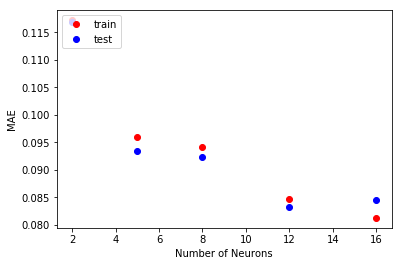

In [31]:
plt.plot(number_neurons, maes, 'ro')
plt.plot(number_neurons, val_maes, 'bo')
plt.xlabel('Number of Neurons')
plt.ylabel('MAE')
plt.legend(['train', 'test'], loc='upper left')

Text(0, 0.5, 'NMSE')

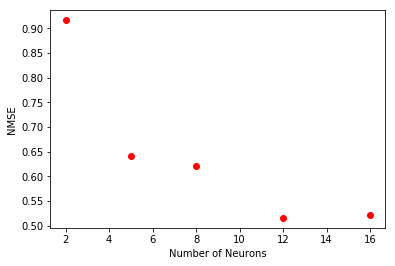

In [32]:
plt.plot(number_neurons, nmses, 'ro')
plt.xlabel('Number of Neurons')
plt.ylabel('NMSE')

In [34]:
 model = get_model_with(inputs, 12)

history = model.fit(inputs, targets, epochs=75, batch_size=1, verbose=1)
history.history['mae']
model.save("nn_12_75.h5")

Epoch 1/75
65341/65341 [==============================] - 73s 1ms/step - loss: 0.0158 - mae: 0.0967
Epoch 2/75
65341/65341 [==============================] - 73s 1ms/step - loss: 0.0124 - mae: 0.0853
Epoch 3/75
65341/65341 [==============================] - 74s 1ms/step - loss: 0.0119 - mae: 0.0838
Epoch 4/75
65341/65341 [==============================] - ETA: 0s - loss: 0.0119 - mae: 0.083 - 75s 1ms/step - loss: 0.0119 - mae: 0.0833
Epoch 5/75
65341/65341 [==============================] - 74s 1ms/step - loss: 0.0123 - mae: 0.0843
Epoch 6/75
65341/65341 [==============================] - 69s 1ms/step - loss: 0.0124 - mae: 0.0849
Epoch 7/75
65341/65341 [==============================] - 93s 1ms/step - loss: 0.0123 - mae: 0.0846
Epoch 8/75
65341/65341 [==============================] - 97s 1ms/step - loss: 0.0117 - mae: 0.0826
Epoch 9/75
65341/65341 [==============================] - 97s 1ms/step - loss: 0.0116 - mae: 0.0824
Epoch 10/75
65341/65341 [==============================] - 97s